In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


# Quora Question Pairs

## 1. Business Problem 
### 1.1 Description
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

_ Problem Statement __
* Identify which questions asked on Quora are duplicates of questions that have already been asked. 
* This could be useful to instantly provide answers to questions that have already been answered. 
* This technique could also be used while filtering the comments section of education websites where doubt questions are asked.

### 1.2 Real World/Business Objectives and Constraints
1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

## 2. Machine Learning Problem


### 2.1 Data
#### 2.1.1 Data Overview
<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Number of rows in Train.csv = 404,290
</p>

### 2.2 Mapping the real world problem to an ML problem
#### 2.2.1 Type of Machine Learning Problem
* Binary Classification Problem

#### 2.2.2 Peformance Metric
* log-loss
* Binary Confusion Matrix

### 2.3 Train and Test Construction
* Split the data in Train.csv in 70:30 ratio

## 3. Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## 3.1 Reading data and basic stats

In [3]:
train = pd.DataFrame()
train = pd.read_csv('../input/quora-question-pairs/train.csv.zip')

In [4]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
train.shape

(404290, 6)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

## 3.2.1 Distribution of data points among output classes
- Number of duplicate and non duplicate questions

<AxesSubplot:xlabel='is_duplicate'>

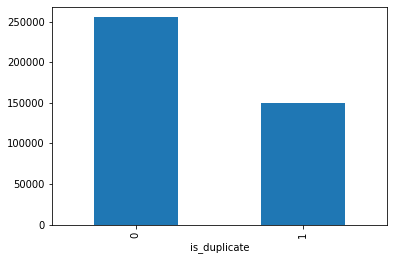

In [7]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [8]:
print("total number of questions in dataset are:- {}".format(len(train)))

total number of questions in dataset are:- 404290


In [9]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(round(len(train[train['is_duplicate']==0])/len(train) * 100),2))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(len(train[train['is_duplicate']==1])/len(train) * 100),2))

~> Question pairs are not Similar (is_duplicate = 0):
   63%

~> Question pairs are Similar (is_duplicate = 1):
   37%


## 3.2.2 Number of unique questions

In [10]:
#store all the question ids in a list 'qids'
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())

#get the unique qids by using np.unique on qids
unique_qs = len(np.unique(qids))

#get the sum of those qids which repeat more than one
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



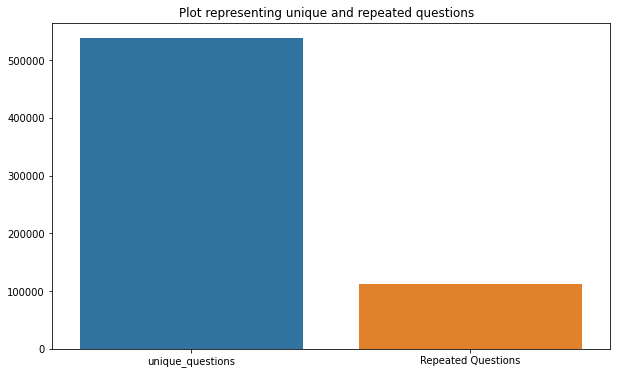

In [11]:
x = ["unique_questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

## 3.2.3 Checking for Duplicates

In [12]:
#checking for duplicate pairs by grouping on qid1 and qid2.
duplicate_pairs = train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("total number of duplicate questions: {}".format(duplicate_pairs.shape[0] - train.shape[0])) 

total number of duplicate questions: 0


## 3.2.4 Number of occurence of each question

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning:

The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Maximum number of times a single question is repeated: 157



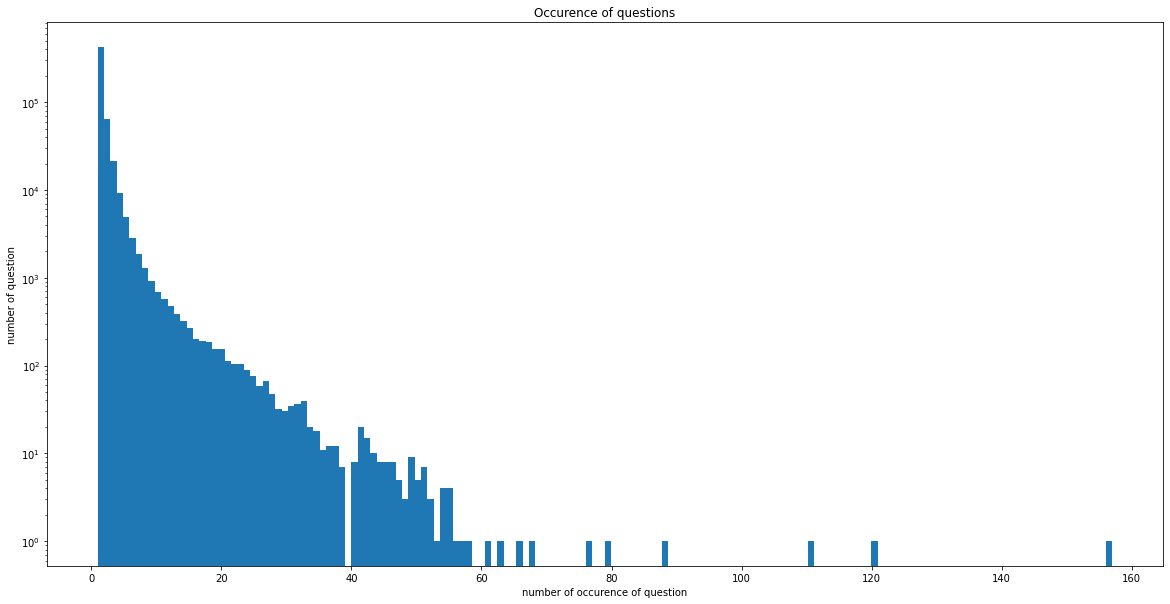

In [13]:
#plot occurences of questions
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)

plt.yscale('log', nonposy='clip')

plt.title("Occurence of questions")
plt.xlabel("number of occurence of question")
plt.ylabel("number of question")

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## 3.2.5 Checking for null values

In [14]:
#check for null values in an entire dataframe
null_rows = train[train.isnull().any(axis = 1)]
null_rows

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


- There are 2 rows with null values
- 2 features with null value which are question1 and question2

In [15]:
#fill the nan values with a space
train = train.fillna(" ")
null_rows = train[train.isnull().any(axis = 1)]
print(null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## 3.3 Basic Feature Extraction before cleaning
* **freq_qid1** = Frequency of qid1's
* **freq_qid2** = Frequency of qid2's
* **q1len** = Length of q1
* **q2len** = Length of q2
* **q1_n_words** = Number of words in Question 1
* **q2_n_words** = Number of words in Question 2
* **word_Common** = (Number of common unique words in Question 1 and Question 2)
* **word_Total** =(Total num of words in Question 1 + Total num of words in Question 2)
* **word_share** = (word_common)/(word_Total)
* **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
* **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [16]:
train['freq_qid1'] = train.groupby('qid1')['qid1'].transform('count') 
train['freq_qid2'] = train.groupby('qid2')['qid2'].transform('count')

train['q1len'] = train['question1'].astype(str).str.len()
train['q2len'] = train['question2'].astype(str).str.len()

train['q1_n_words'] = train['question1'].astype(str).apply(lambda row : len(row.split(" ")))
train['q2_n_words'] = train['question2'].astype(str).apply(lambda row : len(row.split(" ")))

In [17]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [18]:
train.values

array([[0, 1, 2, ..., 57, 14, 12],
       [1, 3, 4, ..., 88, 8, 13],
       [2, 5, 6, ..., 59, 14, 10],
       ...,
       [404287, 537928, 537929, ..., 17, 4, 3],
       [404288, 537930, 537931, ..., 127, 17, 25],
       [404289, 537932, 537933, ..., 45, 8, 10]], dtype=object)

* To get the common unique words we first take the intersection of words in question1 and question2 features and then get their length

In [19]:
train['word_Overlap'] = [set(x[3].split()) & set(x[4].split()) for x in train.values]
train['word_Common'] = train['word_Overlap'].str.len()
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Overlap,word_Common
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,"{invest, guide, in, is, by, What, share, to, t...",10
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,"{What, the, Kohinoor, (Koh-i-Noor)}",4
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,"{How, can, speed}",3
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,{},0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,"{Which, in}",2


In [20]:
train['word_Total'] = train['question1'].str.split().map(len) + train['question2'].str.split().map(len)

In [21]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Overlap,word_Common,word_Total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,"{invest, guide, in, is, by, What, share, to, t...",10,26
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,"{What, the, Kohinoor, (Koh-i-Noor)}",4,21
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,"{How, can, speed}",3,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,{},0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,"{Which, in}",2,20


In [22]:
train.drop('word_Overlap' , axis = 1, inplace = True)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20


In [23]:
train['word_share'] = train['word_Common'] / train['word_Total'] 

In [24]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24,0.125000
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000


In [25]:
train['freq_q1+q2'] = train['freq_qid1'] + train['freq_qid2']
train['freq_q1-q2'] = abs(train['freq_qid1'] - train['freq_qid2'])

In [26]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3


## 3.3.1 Analysis of some of the extracted features

- No of questions that have only single words

In [27]:
#Analysis of extracted features
print ("Minimum length of the questions in question1 : " , min(train['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(train['q2_n_words']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1


In [28]:
print ("Number of Questions with minimum length [question1] :", train[train['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train[train['q2_n_words']== 1].shape[0])

Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


### 3.3.1.1 Feature : word_share

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



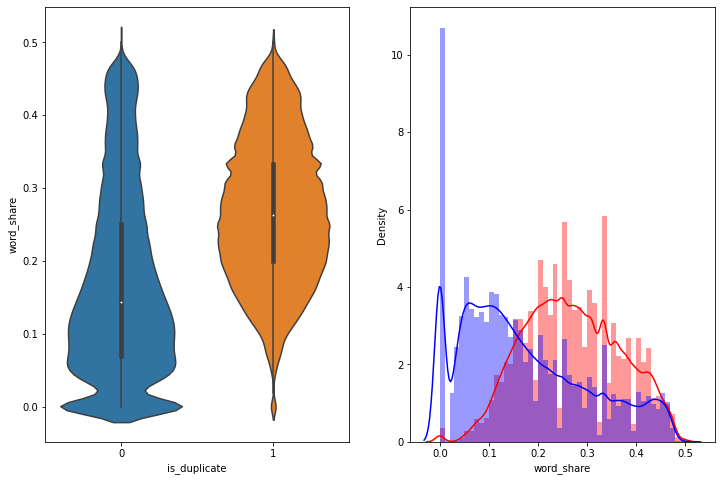

In [29]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

**Questions are duplicate if they have more common words**

### 3.3.1.2 Feature : word_Common

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



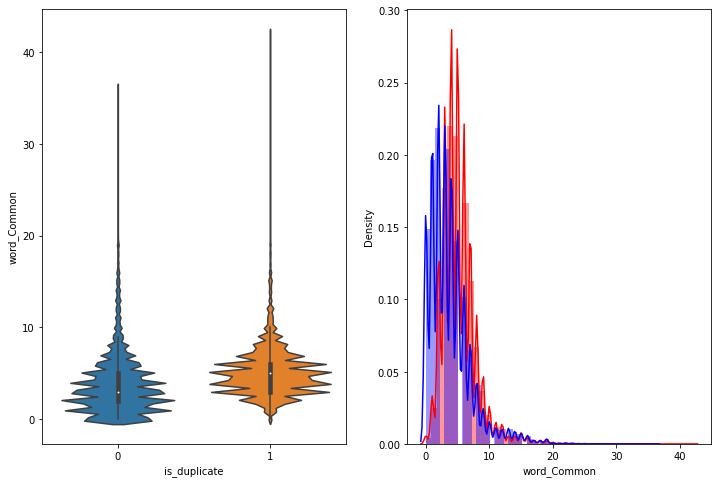

In [30]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = train[0:])

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

The distribution of word_Common features is highly overlapping in both the classes.

In [31]:
train.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3


## 3.4 Preprocessing of Text
* Removing HTML tags
* Remove punctuation
* Stemming
* Removing stop words
* Expanding contractions

Function to clean the text 

In [32]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [33]:
SAFE_DIV = 0.0001

In [36]:
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [34]:
!pip install --user distance

     |████████████████████████████████| 180 kB 808 kB/s eta 0:00:01
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16275 sha256=554d89eeb0f9719321f01ff533f4fac9efd8503b8053fc9ade8ed500faa7528c
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [35]:
def get_token_features(q1, q2):
    
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)    #cwc_min
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)    #cwc_max
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)    #csc_min
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)    #csc_max
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) #ctc_min
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) #ctc_max
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])  #last_word_eq
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])    #first_word_eq
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))  #abs_len_diff
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2   #mean_len
    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [38]:
train = extract_features(train)
train.head()

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


## 3.5  Analysis of Extracted Features

### 3.5.1 Plotting Word Clouds
- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [39]:
train_duplicate = train[train['is_duplicate'] == 1]
train_nonduplicate = train[train['is_duplicate'] == 0]

In [40]:
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([train_duplicate["question1"], train_duplicate["question2"]]).flatten()
n = np.dstack([train_nonduplicate["question1"], train_nonduplicate["question2"]]).flatten()

In [41]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [42]:
#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [43]:
# reading the text files and removing the Stop Words:
#d = path.dirname('.')

textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109877
Total number of words in non duplicate pair questions : 33193004


Word Cloud for Duplicate Question pairs


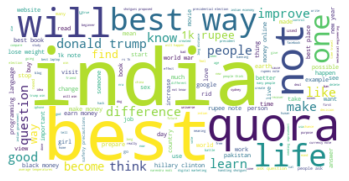

In [44]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


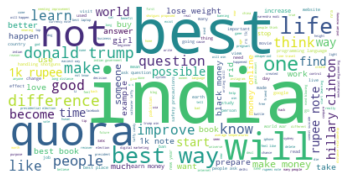

In [45]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3.5.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

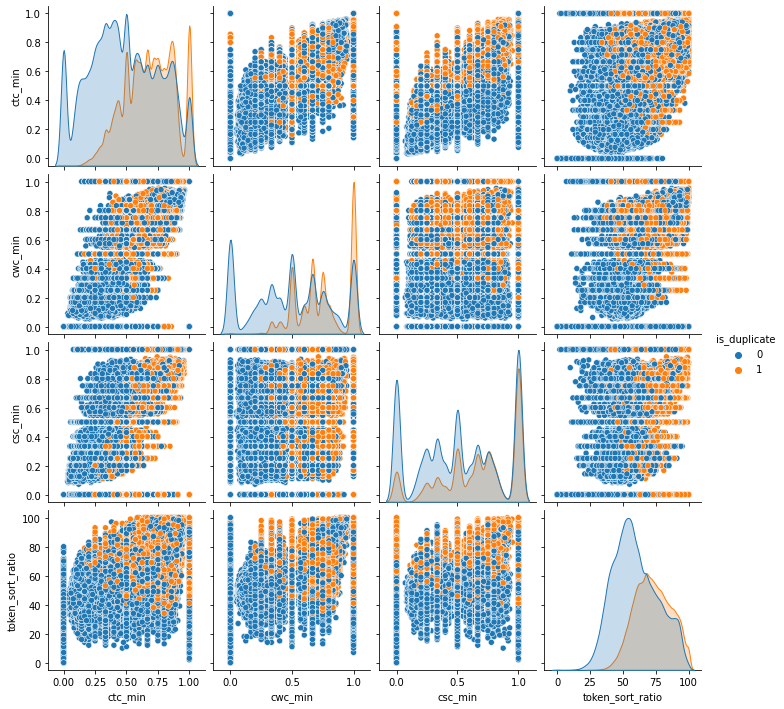

In [46]:
n = train.shape[0]
sns.pairplot(train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [47]:
train.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



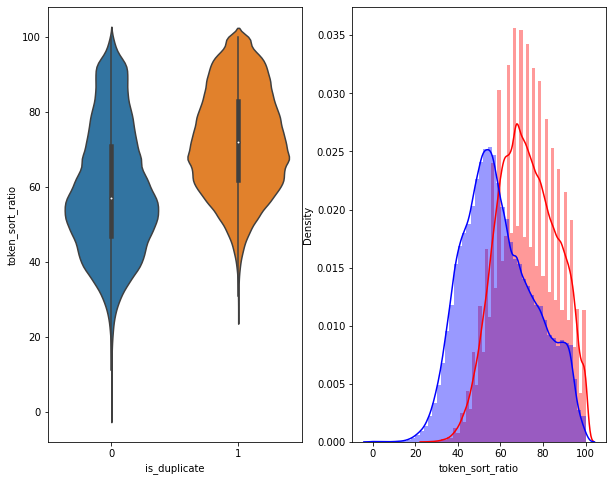

In [48]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



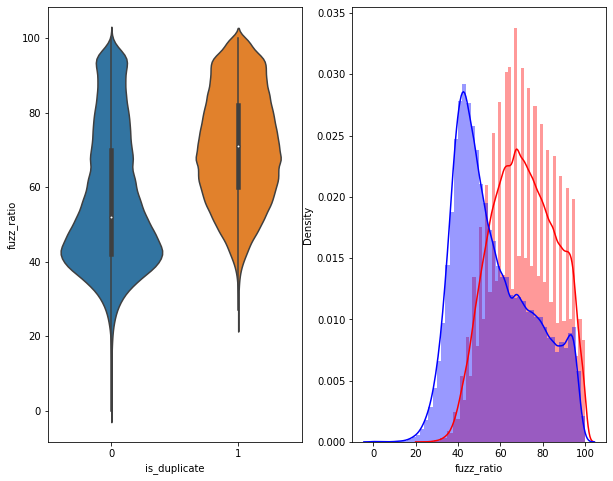

In [49]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = train[0:] , )

plt.subplot(1,2,2)
sns.distplot(train[train['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(train[train['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [50]:
train.shape

(404290, 32)

In [51]:
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


## 4 Splitting of Dataset

In [52]:
y = train['is_duplicate']

In [53]:
#train.drop('is_duplicate',inplace = True,axis = 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(270874, 32)
(133416, 32)
(270874,)
(133416,)


In [54]:
x_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,441499,441500,what is the tattoo written on dmc own head,were tattoos part of the 60 own hippie culture,0,1,1,41,45,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


## 5 Featurizing text data with tfidf avg word2vec

In [55]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


### 5.1 On Train Data

In [56]:
#make a list of all the questions from train data
questions = x_train['question1'] + x_train['question2']

In [57]:
#create a list of all sentences
i = 0
list_of_sentence = []
for sentence in questions:
    list_of_sentence.append(sentence)

In [58]:
import nltk

In [59]:
## tokenize every sentence in your sentence list
list_of_sentence = [nltk.word_tokenize(sent) for sent in list_of_sentence]

Apply Word2Vec from gensim to list_of_sentence to calculate word vectors. 

In [60]:
import gensim
#from gensim.models import Word2Vec
w2vmodel = gensim.models.Word2Vec(list_of_sentence,min_count = 5, vector_size = 50, workers = 4)


Test your word2vec model by getting the words most similar to sun, best etc. We can use any word.

In [61]:
print(w2vmodel.wv.most_similar('sun'))

[('moon', 0.8935983180999756), ('orbit', 0.7782123684883118), ('earth', 0.7490772008895874), ('jupiter', 0.7448316812515259), ('sky', 0.7396214008331299), ('ocean', 0.7296487092971802), ('light', 0.7285628318786621), ('atmosphere', 0.7237616777420044), ('pluto', 0.721756637096405), ('ground', 0.7196139097213745)]


In [62]:
print(w2vmodel.wv.most_similar('best'))

[('easiest', 0.7419774532318115), ('fastest', 0.6772488355636597), ('cheapest', 0.6714219450950623), ('safest', 0.6658583879470825), ('good', 0.6331117153167725), ('healthiest', 0.5729688405990601), ('recommended', 0.5702217221260071), ('coolest', 0.5615788698196411), ('saddest', 0.5497375130653381), ('worst', 0.5480149984359741)]


In [63]:
#store every word in w2v_words list
w2v_words = list(w2vmodel.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  25147
sample words  ['the', 'what', 'is', 'i', 'how', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', 'you', 'why', 'it', 'my', 'best', 'on', 'does', 'or', 'have', 'be', 'which', 'if', 'not', 'some', 'that', 'with', 'get', 'should', 'an', 'from', 'your', 'will', 'india', 'own', 'people', 'who', 'when', 'like', 'at', 'good', 'would', 'there', 'as', 'about', 'between', 'one']


Create a new list_of_sentences and fit TfidfVectorizer on it. 

Transform the list and calculate tfidf value for every n gram

In [64]:
i = 0
list_of_sentences = []
for sentence in questions:
    list_of_sentences.append(sentence)

In [65]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10)
tf_idf_vect.fit(list_of_sentences)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(list_of_sentences)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['00', '000', '00k', '01', '04', '05', '06', '08', '09', '10']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (270874, 15258)
the number of unique words including both unigrams and bigrams  15258


In [66]:
#create a dictionary with key = word and value = idf value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [67]:
dictionary['step']

7.640115825704886

In [68]:
#create a new list for question1 and question2. 
#tokenize every sentence
q1_feat = [nltk.word_tokenize(sent) for sent in x_train['question1']]
q2_feat = [nltk.word_tokenize(sent) for sent in x_train['question2']]

In [69]:
x_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,441499,441500,what is the tattoo written on dmc own head,were tattoos part of the 60 own hippie culture,0,1,1,41,45,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


* **Calulate tfidf weighted w2v for both the features question1 and question2**

In [70]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q1_feat): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q1.append(sent_vec)
    row += 1

100%|██████████| 270874/270874 [12:51<00:00, 351.11it/s]


In [71]:
tfidf_sent_vectors_q1[0:2]

[array([-2.76518504e-01,  5.08700861e-01,  7.68098167e-01, -2.23255562e-01,
        -4.69562196e-01, -3.20766542e-01,  5.17599558e-01,  7.01717997e-02,
         1.28209737e-01,  1.96915814e-02, -6.33098678e-02,  1.43123208e-03,
         4.52746317e-01, -1.53420859e+00, -7.85857063e-01,  1.97934714e-01,
        -4.77280073e-01, -4.95169262e-01,  3.65244274e-01, -3.95134859e-01,
         4.05815339e-01, -4.22649191e-01, -3.95977576e-01, -5.57565626e-01,
         1.58918976e-01, -1.08616162e+00, -3.09103806e-01, -4.50565118e-02,
        -7.81577619e-01,  1.42738532e-01, -4.07455085e-01, -1.02036846e+00,
         9.75950348e-02,  1.64359452e-01,  1.14515624e+00, -1.37235077e-01,
         8.29271947e-02, -8.16251214e-01, -1.10880695e-01, -7.93791684e-01,
         6.76963527e-01, -3.92888477e-01,  6.54855695e-01, -3.29614095e-02,
         5.77037424e-01, -5.97361949e-01, -7.33001836e-02, -5.34578080e-01,
         7.46658231e-02,  7.37748688e-01]),
 array([ 0.24938883,  0.73760924, -1.1230309

In [72]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q2_feat): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q2.append(sent_vec)
    row += 1

100%|██████████| 270874/270874 [12:50<00:00, 351.34it/s]


In [73]:
tfidf_sent_vectors_q2[0:2]

[array([-0.77234457,  0.7056008 , -0.23736187, -0.68249743, -0.82479018,
        -0.02008538,  0.18075432,  0.81750113, -0.49814987, -1.13633474,
         0.73013199,  0.06566705,  0.37862296, -0.87271537,  0.09429932,
         0.20703652, -0.15664583, -0.3771909 , -0.20217947,  0.46167567,
         0.86446336,  1.07138993,  0.17482487, -0.65994795,  1.03846863,
         0.17236415,  0.43774617, -0.21467774, -0.13224123, -0.44849967,
         0.07949391, -0.38077014,  0.3385235 , -0.2487737 ,  0.50438062,
         0.08791591, -0.03004988, -0.42115247,  0.15211252, -1.06281624,
         0.48760203, -0.95298716,  0.46490767, -0.24092609, -0.76370193,
        -0.99948934,  1.2610083 , -0.15840924,  0.48387167, -0.39543721]),
 array([ 0.22204363,  0.65486723, -0.82964213, -0.55014984, -1.66994378,
        -0.98248057,  1.38122778, -0.16867775, -0.46995784,  0.78384248,
         1.09836166,  0.19504112, -1.09239212, -0.74058003,  1.5060675 ,
         0.48235513,  1.14684684,  0.39061156, -1

Merge the values of the vector with our train data set

In [74]:
df = pd.DataFrame()
df['q1_feat'] = list(tfidf_sent_vectors_q1)

In [75]:
df.head()

,q1_feat
0,"[-0.27651850415870083, 0.5087008609597965, 0.7..."
1,"[0.2493888258534772, 0.7376092412746078, -1.12..."
2,"[0.5026991389822527, -0.09136415114323566, 0.4..."
3,"[-0.14827180245554009, 0.7409214939345357, 0.0..."
4,"[0.24352341114102768, 0.2147305925397611, 0.05..."


In [76]:
df['q2_feat'] = list(tfidf_sent_vectors_q2)
df.head()

,q1_feat,q2_feat
0,"[-0.27651850415870083, 0.5087008609597965, 0.7...","[-0.7723445709423234, 0.7056007978077691, -0.2..."
1,"[0.2493888258534772, 0.7376092412746078, -1.12...","[0.22204363410786263, 0.6548672341698096, -0.8..."
2,"[0.5026991389822527, -0.09136415114323566, 0.4...","[-1.7397025590766126, -0.049135602167164436, 0..."
3,"[-0.14827180245554009, 0.7409214939345357, 0.0...","[-0.223098008189822, 0.3386734331783942, 0.077..."
4,"[0.24352341114102768, 0.2147305925397611, 0.05...","[0.5946622553801378, -1.058721056969196, 0.291..."


In [77]:
df3_q1 = pd.DataFrame(df.q1_feat.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df.q2_feat.values.tolist(), index= df.index)

In [78]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.276519,0.508701,0.768098,-0.223256,-0.469562,-0.320767,0.517600,0.070172,0.128210,0.019692,...,0.676964,-0.392888,0.654856,-0.032961,0.577037,-0.597362,-0.073300,-0.534578,0.074666,0.737749
1,0.249389,0.737609,-1.123031,-0.605923,-2.223422,-0.752304,0.947955,-0.779739,-0.201403,0.678125,...,2.474360,0.364107,-0.446848,-0.255124,1.035895,-0.113328,0.023487,0.394498,0.154654,1.072283
2,0.502699,-0.091364,0.421366,-0.331548,-0.731715,0.262120,-0.158701,-0.591150,0.555968,-0.670373,...,1.920111,-0.157907,-1.130050,-0.595265,0.391297,-1.214804,0.845907,-1.651579,0.846190,-0.460187
3,-0.148272,0.740921,0.082697,0.154251,-0.930427,-0.146221,0.310969,0.521902,0.331411,-0.388908,...,0.457009,-0.461635,0.534756,-0.733064,-0.390700,-0.685363,-0.118965,-0.862251,0.075750,-0.216148
4,0.243523,0.214731,0.051058,0.063739,-0.371806,0.362847,-0.295202,0.726215,0.627917,-0.430875,...,0.232213,-0.312331,0.110894,-0.116387,0.463665,-0.653646,0.417012,-0.795888,0.437042,0.573805


In [79]:
x_train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,441499,441500,what is the tattoo written on dmc own head,were tattoos part of the 60 own hippie culture,0,1,1,41,45,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


In [80]:
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.772345,0.705601,-0.237362,-0.682497,-0.824790,-0.020085,0.180754,0.817501,-0.498150,-1.136335,...,0.487602,-0.952987,0.464908,-0.240926,-0.763702,-0.999489,1.261008,-0.158409,0.483872,-0.395437
1,0.222044,0.654867,-0.829642,-0.550150,-1.669944,-0.982481,1.381228,-0.168678,-0.469958,0.783842,...,2.674081,0.877448,-1.066162,-0.478172,1.428902,-0.183332,0.715909,0.307079,0.599602,0.795516
2,-1.739703,-0.049136,0.536306,0.990054,-0.040042,-1.025912,1.833417,0.772825,-1.271128,-1.285225,...,-0.398595,-0.830579,-0.759564,1.124377,-1.415587,-0.952738,0.822006,-0.194544,-1.457874,1.565405
3,-0.223098,0.338673,0.077128,-0.310779,-0.807544,-0.216537,0.579317,0.324228,0.259044,-0.650604,...,0.240212,-0.042204,0.431265,0.243570,-0.035928,-0.367044,0.298314,-0.543526,0.650187,-0.039818
4,0.594662,-1.058721,0.291568,0.606493,-0.780419,0.320748,-0.449923,0.796701,0.188150,0.302468,...,0.025028,0.322539,0.039355,-0.047934,0.292645,0.172143,-0.319120,-0.940538,-0.561059,0.246429


In [81]:
x_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

Drop the columns which aren't needed

In [82]:
x_train.drop(['qid1', 'qid2', 'question1', 'question2'],inplace = True, axis = 1)
#train.head

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4908: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
x_train.head(1)

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
316451,316451,0,1,1,41,45,8,8,1,16,...,0.22222,0.0,0.0,0.0,9.0,57,57,50,53,0.181818


In [84]:
x_train = x_train.reset_index()
x_train.head()

,index,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,316451,316451,0,1,1,41,45,8,8,1,...,0.222220,0.0,0.0,0.0,9.0,57,57,50,53,0.181818
1,398368,398368,1,1,1,59,69,11,12,6,...,0.583328,0.0,1.0,1.0,11.5,93,82,67,66,0.433333
2,218253,218253,0,1,1,21,47,5,8,0,...,0.000000,0.0,0.0,3.0,6.5,41,41,34,43,0.136364
3,282919,282919,0,1,1,43,23,6,4,1,...,0.499992,0.0,0.0,2.0,5.0,87,55,54,78,0.750000
4,243365,243365,0,1,1,52,69,9,14,0,...,0.071428,0.0,0.0,5.0,11.5,50,50,44,52,0.150943


In [85]:
df3_q1['id']= x_train['id']
df3_q2['id']= x_train['id']
#result  = df1.merge(df2, on='id',how='left')

In [86]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,id
0,-0.276519,0.508701,0.768098,-0.223256,-0.469562,-0.320767,0.517600,0.070172,0.128210,0.019692,...,-0.392888,0.654856,-0.032961,0.577037,-0.597362,-0.073300,-0.534578,0.074666,0.737749,316451
1,0.249389,0.737609,-1.123031,-0.605923,-2.223422,-0.752304,0.947955,-0.779739,-0.201403,0.678125,...,0.364107,-0.446848,-0.255124,1.035895,-0.113328,0.023487,0.394498,0.154654,1.072283,398368
2,0.502699,-0.091364,0.421366,-0.331548,-0.731715,0.262120,-0.158701,-0.591150,0.555968,-0.670373,...,-0.157907,-1.130050,-0.595265,0.391297,-1.214804,0.845907,-1.651579,0.846190,-0.460187,218253
3,-0.148272,0.740921,0.082697,0.154251,-0.930427,-0.146221,0.310969,0.521902,0.331411,-0.388908,...,-0.461635,0.534756,-0.733064,-0.390700,-0.685363,-0.118965,-0.862251,0.075750,-0.216148,282919
4,0.243523,0.214731,0.051058,0.063739,-0.371806,0.362847,-0.295202,0.726215,0.627917,-0.430875,...,-0.312331,0.110894,-0.116387,0.463665,-0.653646,0.417012,-0.795888,0.437042,0.573805,243365


In [87]:
x_train  = x_train.merge(df3_q1, on='id',how='left')
x_train = x_train.merge(df3_q2, on='id',how='left')

In [88]:
x_train.head(5)

,index,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,316451,316451,0,1,1,41,45,8,8,1,...,0.487602,-0.952987,0.464908,-0.240926,-0.763702,-0.999489,1.261008,-0.158409,0.483872,-0.395437
1,398368,398368,1,1,1,59,69,11,12,6,...,2.674081,0.877448,-1.066162,-0.478172,1.428902,-0.183332,0.715909,0.307079,0.599602,0.795516
2,218253,218253,0,1,1,21,47,5,8,0,...,-0.398595,-0.830579,-0.759564,1.124377,-1.415587,-0.952738,0.822006,-0.194544,-1.457874,1.565405
3,282919,282919,0,1,1,43,23,6,4,1,...,0.240212,-0.042204,0.431265,0.243570,-0.035928,-0.367044,0.298314,-0.543526,0.650187,-0.039818
4,243365,243365,0,1,1,52,69,9,14,0,...,0.025028,0.322539,0.039355,-0.047934,0.292645,0.172143,-0.319120,-0.940538,-0.561059,0.246429


In [89]:
x_train.drop('index',inplace=True,axis = 1)

In [90]:
x_train.head(1)

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,316451,0,1,1,41,45,8,8,1,16,...,0.487602,-0.952987,0.464908,-0.240926,-0.763702,-0.999489,1.261008,-0.158409,0.483872,-0.395437


## 5.2 On Test Data
Use the above fitted w2v and tfidfvectorizers to transform test data.

In [91]:
x_test.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,2,2,34,34,...,0.874989,0.0,1.0,0.0,8.0,90,81,88,88,0.800000
368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,5,2,53,51,...,0.545450,0.0,1.0,2.0,10.0,73,73,73,73,0.326923


In [92]:
q1_feat_tst = [nltk.word_tokenize(sent) for sent in x_test['question1']]
q2_feat_tst = [nltk.word_tokenize(sent) for sent in x_test['question2']]

In [93]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q1_tst = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q1_feat_tst): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q1_tst.append(sent_vec)
    row += 1

100%|██████████| 133416/133416 [06:20<00:00, 350.74it/s]


In [94]:
import tqdm  
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_q2_tst = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm.tqdm(q2_feat_tst): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    #print(sent)
    for word in sent: # for each word in a review/sentence
        #print('each word')
        #print(word)
        if word in w2v_words and word in tfidf_feat:
            vec = w2vmodel.wv[word]
            #print('vector')
            #print(vec)
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_q2_tst.append(sent_vec)
    row += 1

100%|██████████| 133416/133416 [06:21<00:00, 349.76it/s]


In [95]:
tfidf_sent_vectors_q1_tst[0]

array([-0.01281183, -0.19864276,  0.18876917,  1.03680243, -1.39033428,
       -0.90407381,  0.41407113,  0.09232992,  0.33223821, -0.86738039,
       -0.49438971, -0.23278229, -0.76747125, -0.21830326, -0.70087278,
       -1.08492653, -1.19272338,  0.05998107, -0.26303214,  0.22491258,
        0.49653075, -1.15292956,  0.24253151, -0.42976972, -0.34916883,
       -0.09736381,  0.40528633, -0.8075057 , -0.22661765,  0.49175691,
        0.60721798,  0.53748801,  0.60539293, -0.5430882 , -0.46868982,
       -0.35699289, -0.06128827, -0.08551397,  0.96541675, -0.7683851 ,
       -1.20666176,  0.36683988, -1.73379805, -0.81291924, -1.06944106,
       -3.25824591,  0.77757877, -1.76602106, -0.11621335, -0.58748984])

In [96]:
df = pd.DataFrame()
df['q1_feat'] = list(tfidf_sent_vectors_q1_tst)
#df = pd.DataFrame()
df['q2_feat'] = list(tfidf_sent_vectors_q2_tst)

In [97]:
df.head()

,q1_feat,q2_feat
0,"[-0.012811828167255485, -0.1986427578521814, 0...","[0.16458744528892463, 0.10285888453576902, 0.2..."
1,"[0.9096180836564496, 0.4543161537919444, 0.301...","[1.1952406460400764, 0.5701180730204077, 0.722..."
2,"[0.437820520274292, 0.3286546618110713, -0.091...","[-0.23637512431389535, -0.4477857427487874, -0..."
3,"[-2.3533062286808266, -0.8347793785274478, 0.2...","[-1.7055658554671187, -1.0274566631381632, 0.2..."
4,"[-0.1858043358311169, -0.9964914467738091, 0.0...","[-0.025899572262465823, -0.3243043087523348, 0..."


In [98]:
df3_q1 = pd.DataFrame(df.q1_feat.values.tolist(), index= df.index)
df3_q2 = pd.DataFrame(df.q2_feat.values.tolist(), index= df.index)

In [99]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.012812,-0.198643,0.188769,1.036802,-1.390334,-0.904074,0.414071,0.092330,0.332238,-0.867380,...,-1.206662,0.366840,-1.733798,-0.812919,-1.069441,-3.258246,0.777579,-1.766021,-0.116213,-0.587490
1,0.909618,0.454316,0.301243,-0.138752,-1.327769,-1.103722,0.579915,0.553431,0.246342,0.699717,...,1.026545,1.068962,-0.559348,-0.371253,0.586977,0.235791,0.252026,-0.015751,0.355307,1.055980
2,0.437821,0.328655,-0.091357,0.400309,-0.130638,-0.079307,-0.259637,0.605775,0.336338,0.023039,...,-0.275627,0.263938,0.174991,-1.371081,0.374859,0.050613,-0.117719,-0.383832,-0.708445,0.551927
3,-2.353306,-0.834779,0.247827,1.809292,-1.608993,-0.229992,0.779966,2.713298,-0.448862,1.216244,...,0.049864,-1.008182,-0.621744,-2.815970,0.931225,-0.602885,0.896011,1.088086,-1.921863,0.150403
4,-0.185804,-0.996491,0.018798,-0.044535,-0.581457,-0.180868,0.167680,0.743898,0.566134,-0.801451,...,0.211837,-1.050783,-0.517418,-0.861487,-2.055938,-1.625918,0.411929,-1.645566,0.917014,0.032919


In [100]:
x_test = x_test.reset_index()
x_test.head()

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,2,2,34,...,0.874989,0.0,1.0,0.0,8.0,90,81,88,88,0.800000
1,368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,5,2,53,...,0.545450,0.0,1.0,2.0,10.0,73,73,73,73,0.326923
2,70497,70497,121486,121487,which is more advisable and better material fo...,what is the best server setup for buddypress,0,1,1,96,...,0.124999,0.0,0.0,8.0,12.0,41,39,39,44,0.108696
3,226567,226567,254474,258192,how do i improve logical programming skills,how can i improve my logical skills for progra...,1,2,2,44,...,0.666659,0.0,1.0,2.0,8.0,96,89,72,68,0.288889
4,73186,73186,48103,3062,how close we are to see 3rd world war,how close is a world war iii,1,4,31,38,...,0.444440,0.0,1.0,2.0,8.0,81,71,68,62,0.366667


In [101]:
df3_q1['id']= x_test['id']
df3_q2['id']= x_test['id']
#result  = df1.merge(df2, on='id',how='left')

In [102]:
x_test = x_test.merge(df3_q1, on='id',how='left')
x_test = x_test.merge(df3_q2, on='id',how='left')

In [103]:
x_test.head(2)

,index,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,8067,8067,15738,15739,how do i play pokémon go in korea,how do i play pokémon go in china,0,2,2,34,...,-1.419569,0.429921,-1.464943,-0.997815,-1.418791,-2.753285,0.844068,-1.892507,-0.315633,-0.868397
1,368101,368101,12736,104117,what are some of the best side dishes for crab...,what are some good side dishes for buffalo chi...,0,5,2,53,...,1.279863,1.329166,-0.836257,-0.614351,0.852310,-0.227526,0.460441,-0.194046,0.419518,1.240070


In [104]:
x_test.columns

Index(['index', 'id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len',
       ...
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y'],
      dtype='object', length=133)

In [105]:
x_train.columns

Index(['id', 'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       ...
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y'],
      dtype='object', length=128)

In [106]:
x_test.drop(['index','qid1', 'qid2', 'question1', 'question2'],axis = 1, inplace = True)

In [107]:
x_test.columns

Index(['id', 'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
       ...
       '40_y', '41_y', '42_y', '43_y', '44_y', '45_y', '46_y', '47_y', '48_y',
       '49_y'],
      dtype='object', length=128)

In [108]:
x_test.drop('id',inplace = True,axis = 1)
x_train.drop('id',inplace = True,axis = 1)

In [109]:
x_train.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,1,1,41,45,8,8,1,16,0.06250,...,0.487602,-0.952987,0.464908,-0.240926,-0.763702,-0.999489,1.261008,-0.158409,0.483872,-0.395437
1,1,1,1,59,69,11,12,6,23,0.26087,...,2.674081,0.877448,-1.066162,-0.478172,1.428902,-0.183332,0.715909,0.307079,0.599602,0.795516
2,0,1,1,21,47,5,8,0,13,0.00000,...,-0.398595,-0.830579,-0.759564,1.124377,-1.415587,-0.952738,0.822006,-0.194544,-1.457874,1.565405
3,0,1,1,43,23,6,4,1,10,0.10000,...,0.240212,-0.042204,0.431265,0.243570,-0.035928,-0.367044,0.298314,-0.543526,0.650187,-0.039818
4,0,1,1,52,69,9,14,0,23,0.00000,...,0.025028,0.322539,0.039355,-0.047934,0.292645,0.172143,-0.319120,-0.940538,-0.561059,0.246429


In [110]:
x_test.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,0,2,2,34,34,8,8,7,16,0.437500,...,-1.419569,0.429921,-1.464943,-0.997815,-1.418791,-2.753285,0.844068,-1.892507,-0.315633,-0.868397
1,0,5,2,53,51,11,9,6,20,0.300000,...,1.279863,1.329166,-0.836257,-0.614351,0.852310,-0.227526,0.460441,-0.194046,0.419518,1.240070
2,0,1,1,96,45,16,8,2,24,0.083333,...,-0.376273,1.631245,0.063895,-1.029294,0.646722,1.348681,0.484329,0.261589,-0.154648,0.849868
3,1,2,2,44,52,7,9,4,16,0.250000,...,-0.234697,-0.783128,-0.215597,-2.481009,1.173782,-0.247882,0.308951,0.685804,-1.774199,0.107104
4,1,4,31,38,29,9,7,2,16,0.125000,...,-0.889958,-1.593117,-0.975381,-0.899860,-2.623973,-1.642951,0.085579,-1.569795,1.429511,-0.336446


In [111]:
y_train.head()

316451    0
398368    1
218253    0
282919    0
243365    0
Name: is_duplicate, dtype: int64

In [112]:
y_test.head()

8067      0
368101    0
70497     0
226567    1
73186     1
Name: is_duplicate, dtype: int64

In [113]:
x_train.shape

(270874, 127)

In [114]:
x_train.drop('is_duplicate',axis = 1, inplace = True)
x_test.drop('is_duplicate',axis = 1, inplace = True)

## 6. Final Train and Test Datasets

In [116]:
x_test.shape

(133416, 126)

In [117]:
x_test.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,2,2,34,34,8,8,7,16,0.437500,4,...,-1.419569,0.429921,-1.464943,-0.997815,-1.418791,-2.753285,0.844068,-1.892507,-0.315633,-0.868397
1,5,2,53,51,11,9,6,20,0.300000,7,...,1.279863,1.329166,-0.836257,-0.614351,0.852310,-0.227526,0.460441,-0.194046,0.419518,1.240070
2,1,1,96,45,16,8,2,24,0.083333,2,...,-0.376273,1.631245,0.063895,-1.029294,0.646722,1.348681,0.484329,0.261589,-0.154648,0.849868
3,2,2,44,52,7,9,4,16,0.250000,4,...,-0.234697,-0.783128,-0.215597,-2.481009,1.173782,-0.247882,0.308951,0.685804,-1.774199,0.107104
4,4,31,38,29,9,7,2,16,0.125000,35,...,-0.889958,-1.593117,-0.975381,-0.899860,-2.623973,-1.642951,0.085579,-1.569795,1.429511,-0.336446


In [118]:
x_train.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,40_y,41_y,42_y,43_y,44_y,45_y,46_y,47_y,48_y,49_y
0,1,1,41,45,8,8,1,16,0.06250,2,...,0.487602,-0.952987,0.464908,-0.240926,-0.763702,-0.999489,1.261008,-0.158409,0.483872,-0.395437
1,1,1,59,69,11,12,6,23,0.26087,2,...,2.674081,0.877448,-1.066162,-0.478172,1.428902,-0.183332,0.715909,0.307079,0.599602,0.795516
2,1,1,21,47,5,8,0,13,0.00000,2,...,-0.398595,-0.830579,-0.759564,1.124377,-1.415587,-0.952738,0.822006,-0.194544,-1.457874,1.565405
3,1,1,43,23,6,4,1,10,0.10000,2,...,0.240212,-0.042204,0.431265,0.243570,-0.035928,-0.367044,0.298314,-0.543526,0.650187,-0.039818
4,1,1,52,69,9,14,0,23,0.00000,2,...,0.025028,0.322539,0.039355,-0.047934,0.292645,0.172143,-0.319120,-0.940538,-0.561059,0.246429


## 7 ML Models

**We'll be using SGD Classifier with Logistic Regression and SVM**

In [129]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier

## 7.1 Logistic Regression with Hyperparameter tuning

In [144]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, max_iter = 2000)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.41159027061337067
For values of alpha =  0.0001 The log loss is: 0.454478898489064
For values of alpha =  0.001 The log loss is: 0.4500367507564322
For values of alpha =  0.01 The log loss is: 0.42359582971243714
For values of alpha =  0.1 The log loss is: 0.4329003827241569
For values of alpha =  1 The log loss is: 0.48125197312176543
For values of alpha =  10 The log loss is: 0.5387191135837727


In [145]:
best_alpha = np.argmin(log_error_array)
print(best_alpha)

0


In [146]:
clf.classes_

array([0, 1])

In [147]:
log_error_array

[0.41159027061337067,
 0.454478898489064,
 0.4500367507564322,
 0.42359582971243714,
 0.4329003827241569,
 0.48125197312176543,
 0.5387191135837727]

0.412
0.454
0.45
0.424
0.433
0.481
0.539


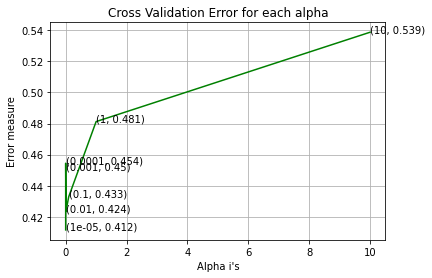

In [148]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    print(txt)
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [149]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,max_iter = 2000)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, loss='log',
                                                    max_iter=2000,
                                                    random_state=42))

In [150]:
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
#plot_confusion_matrix(y_test, predicted_y)

For values of best alpha =  1e-05 The train log loss is: 0.410290264394968
For values of best alpha =  1e-05 The test log loss is: 0.41159027061337067
Total number of data points : 133416


In [151]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted_y)

array([[74591,  9384],
       [17595, 31846]])

In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predicted_y)))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test,predicted_y, target_names=['0', '1']))


Accuracy: 0.80


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     83975
           1       0.77      0.64      0.70     49441

    accuracy                           0.80    133416
   macro avg       0.79      0.77      0.77    133416
weighted avg       0.80      0.80      0.79    133416



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



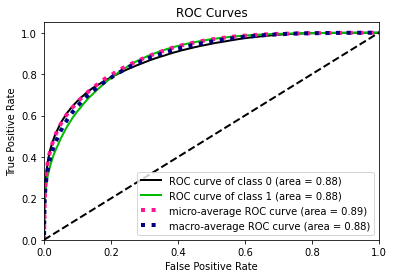

In [153]:
import scikitplot as skplt
import matplotlib.pyplot as plt


skplt.metrics.plot_roc_curve(y_test, predict_y)
plt.show()

## 7.2 SVM with Hyperparameter Tuning

In [134]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,max_iter = 2000)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.435703754268366
For values of alpha =  0.0001 The log loss is: 0.4380544465576106
For values of alpha =  0.001 The log loss is: 0.4431948041429172
For values of alpha =  0.01 The log loss is: 0.47332437276765604
For values of alpha =  0.1 The log loss is: 0.4981344102478357
For values of alpha =  1 The log loss is: 0.5728424357906338


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



For values of alpha =  10 The log loss is: 0.595957139294287


In [135]:
best_alpha = np.argmin(log_error_array)
print(best_alpha)

0


0.436
0.438
0.443
0.473
0.498
0.573
0.596


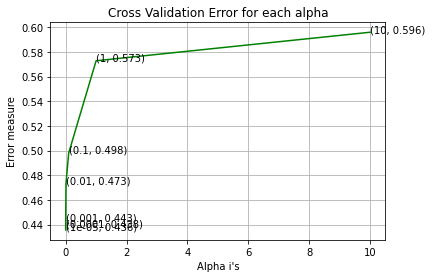

In [136]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    print(txt)
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [137]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,max_iter = 2000)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, max_iter=2000,
                                                    penalty='l1',
                                                    random_state=42))

In [138]:
predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  1e-05 The train log loss is: 0.4348242007990333
For values of best alpha =  1e-05 The test log loss is: 0.435703754268366
Total number of data points : 133416


In [139]:
predict_y[5:10]

array([[0.04549124, 0.95450876],
       [0.61334418, 0.38665582],
       [0.79477762, 0.20522238],
       [0.69334957, 0.30665043],
       [0.34850993, 0.65149007]])

In [140]:
predicted_y[5:10]

array([1, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted_y)

In [141]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, predicted_y)))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test,predicted_y, target_names=['0', '1']))


Accuracy: 0.78


Classification Report

              precision    recall  f1-score   support

           0       0.80      0.87      0.83     83975
           1       0.74      0.63      0.68     49441

    accuracy                           0.78    133416
   macro avg       0.77      0.75      0.76    133416
weighted avg       0.78      0.78      0.78    133416



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



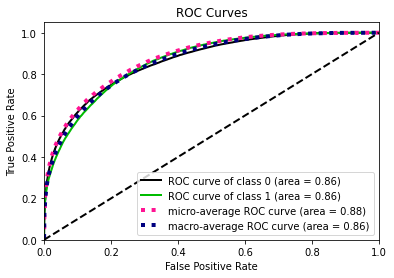

In [143]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, predict_y)
plt.show()